In [11]:
import MDAnalysis as mda
import numpy as np
import sys
import matplotlib.pyplot as plt
nav = mda.units.N_Avogadro

    
import time
import gc
gc.collect()

0

In [36]:
class FormFactor(object):
    def __init__(self, conf,traj,nbin,bsize,output,center,electron="electrons.dat",FF_range=1000):
        """--- Form Factor Calculation ---
        
        Calculates form factors from each ts of trajectory by integration (FFT hopeffuly implemented later)
        
        Inputs: configuration, conf
                trajectory, traj
                number of bins, nbin - same for final density and FF calculations, 
                                       for final density: bins are set before calculations and always same width
                                       for FF calculations: bins width changes for every ts with box size
                size of a box, bsize - for final density calculation, MUST be bigger than bigest box size 
                                       for FF calculations, box size is automatically read from trajectory
                output name, output
                atom selection for centering density profiles for FF calculations, center
                dictonary file with number of electrons, electron="electrons.dat"
                number of integration terms for FF calculations, FF_range=1000
                
        Outputs: density profile averaged over ts, calculated with nbin and bsize
                 cut of this density with minimal box size for awk testing
                 form factor calculated from final density
                 form factor calculated from individual ts, including errors
        """
        
        self.conf = conf   #configuration (tpr) file
        self.traj = traj   #trajectory file
        self.center = center #atom selection for centering for density calculation, string, as in VMD 
        self.nbin = nbin   #number of bins, same for average density, and FF from individual time steps
        self.bsize = bsize #predefined box size [nm] for average density, MUST be bigger that the biggest box size  
        self.output = output
        self.electron = electron
        self.FF_range = FF_range
        
 
        #creates the universe
        start_time=time.time()
        self.u = mda.Universe(self.conf,self.traj)
        print("Loading the trajectory takes {:10.6f} s".format(time.time()-start_time))       
        
        
        self.calculate_weight()
        #self.wght=wght
        self.calculate_density()
        

 
       
    def calculate_weight(self):
        """ --- Assign weights to all atoms ---
        
        Loads a file with atom names and number of electrons.
        Creates a dictonary of atom types.
        Creates a list with number of electrons for all atoms, self.wght, to calculate electron density
        
        
        """
        start_time=time.time()
        with open (self.electron) as f:
            rawdata = f.read().split('\n')
            lines= rawdata[0:len(rawdata)-1]
            tmp_atoms = np.asarray([l.split()[0:2] for l in lines])
            electrons = dict([ (elem[0],int(elem[1])) for elem in tmp_atoms])
        print("Loading of electron mapping takes {:10.6f} s".format(time.time()-start_time))
        

        start_time=time.time()
        wght=np.zeros(self.u.atoms.names.shape[0])
        for i in range (0,self.u.atoms.names.shape[0]):
            wght[i]=electrons[self.u.atoms.names[i]]
        self.wght=wght    
        print("Creating the electron mapping dictonary takes {:10.6f} s".format(time.time()-start_time))

    def calculate_density(self):
        """ --- Density and Form Factor calculation ---
        
        returns 2 density files (1 full, 1 truncated to min z-box size)
                2 form factor files
                
        plots 2 ways of calculating FF
        
        """
        
        central_atoms = self.u.select_atoms(self.center)
        bin_width_constant =  2*self.bsize/ self.nbin 
        box_z_predefined_big = self.bsize
        final_dens_z_coor = np.linspace(-box_z_predefined_big,box_z_predefined_big,self.nbin+1)[:-1] + bin_width_constant/2
        cumulative_density = np.zeros(self.nbin)                 #store final density
        FF_cos=[]                                             #store real part of FF
        FF_sin=[]                                             #imaginary part

        
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        """Calculte density profiles and FF from individual frames"""
        start_time=time.time()
        min_z=10000000
        for ts in self.u.trajectory:
            
            frame = ts.frame #starts with zero
                        
            box_z = ts.dimensions[2]/10
            if box_z<min_z:
                min_z=box_z
            
            ###################################
            """Center in z-direction by given atomic selection"""
            crds = self.u.atoms.positions                                    #all atoms
            com_z_central_atoms = central_atoms.atoms.center_of_mass()[2]/10 #center of mass, z-coordinate
            crds[:,2] += box_z/2 - com_z_central_atoms                       # COM at box_z/2
            self.u.atoms.positions = crds                                    #back-assign to universe
            self.u.atoms.pack_into_box()          #it possibly does not take PBC into account
                                                  # may brake some of the water molecules;
                                                  #come to the issue later   
            crds_z = self.u.atoms.positions[:,2]/10 - box_z/2                #center at 0
            
            
            
            ###################################
            """Final average density - bin width constant, volume changes"""
            vbin = bin_width_constant*np.prod(ts.dimensions[:2])/100     #volume of a bin [nm^3]
            cumulative_density += np.histogram(crds_z,bins=self.nbin,range=(-box_z_predefined_big,box_z_predefined_big),weights=self.wght/vbin)[0]
            
            
            
           
            ###################################
            """Running Form Factor - bin width changes, volume changes"""
            #start_time2=time.time()
            bin_width_running =  box_z/ self.nbin
            vbin_FF =bin_width_running*np.prod(ts.dimensions[:2])/100    #volume [nm^3]
            ff_density=np.histogram(crds_z,bins=self.nbin,range=(-box_z/2,box_z/2),weights=self.wght/vbin_FF)[0]
            
            FF_range = np.linspace(0,self.FF_range-1,self.FF_range)  
            FF_cos_run,FF_sin_run=self.fourier(ff_density,ts.dimensions[2]/10,FF_range,bin_width_running)
              
            FF_cos.append(FF_cos_run)
            FF_sin.append(FF_sin_run)
            #print("One furier loop takes {:10.6f} s".format(time.time()-start_time2))
            #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
         
        print("Calculating the density and FF takes {:10.6f} s".format(time.time()-start_time))


        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        """ Processing and saving density data """
        cumulative_density /= (frame+1)     #becomes average density
        density_data = np.vstack((final_dens_z_coor,cumulative_density)).transpose()
        
        #indexes to truncate data to min box-z dimention
        final_FF_start=int(np.round(self.nbin/2-min_z/bin_width_constant/2))+1
        final_FF_end=int(np.round(self.nbin/2+min_z/bin_width_constant/2))-1
        
         
        with open(str(self.output)+".finalDensity", 'wb') as f:
            np.savetxt(f, density_data,fmt='%8.4f  %.8f')

        with open(str(self.output)+".finalDensity_truncated", 'wb') as f:
            np.savetxt(f, density_data[final_FF_start+1:final_FF_end-1,:],fmt='%8.4f  %.8f')
      



        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        """ Processing and saving form factor data calculated at every frame """
        
        FF_cos_avg = np.average(FF_cos,axis=0)
        FF_sin_avg = np.average(FF_sin,axis=0)
        FF_cos_err = np.std(FF_cos,axis=0)/np.sqrt(frame+1)
        FF_sin_err = np.std(FF_sin,axis=0) /np.sqrt(frame+1)
        
        fourrier_result= np.sqrt(np.multiply(FF_cos_avg,FF_cos_avg)+np.multiply(FF_sin_avg,FF_sin_avg))
        #calculate error by (fa*fa_err + fb*fb_err)/ sqrt(fa^2+fb^2)
        fourrier_error= np.multiply(1/(np.multiply(FF_cos_avg,FF_cos_err)+np.multiply(FF_sin_avg,FF_sin_err)),fourrier_result)
        fourrier_data= np.vstack((FF_range*0.1*0.01,fourrier_result,fourrier_error)).transpose()
        
        with open(str(self.output)+".fourierFromEveryFrame", 'wb') as f:
            np.savetxt(f, fourrier_data,fmt='%8.4f  %.8f %.8f')
        
        
        
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        """ Processing and saving form factor data calculated from final density """        
        fa_aver, fb_aver = self.fourier(density_data[final_FF_start:final_FF_end,1],density_data[final_FF_end,0]-density_data[final_FF_start,0],FF_range,density_data[1,0]-density_data[0,0])
        fourrier_result2= np.sqrt(np.multiply(fa_aver,fa_aver)+np.multiply(fb_aver,fb_aver))
        fourrier_data2 = np.vstack((FF_range*0.1*0.01,fourrier_result2)).transpose()
        
        with open(str(self.output)+".fourierFromFinalDensity", 'wb') as f:
            np.savetxt(f, fourrier_data2,fmt='%8.4f  %.8f')
  
    
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        """Ploting data"""
        self.plot_density(density_data[final_FF_start:final_FF_end,:])
        self.plot_density(density_data)
        self.plot_fourier_final_run(fourrier_data,fourrier_data2)
        


               
        
        
        
        
    def plot_density(self,data):
        plt.figure(figsize=(15, 6))
        plt.plot(data[:,0],data[:,1])
        plt.xlabel("Membrane normal [nm]")
        plt.show()
        
    
    def plot_fourier(self,data):
        plt.figure(figsize=(15, 6))
        plt.plot(data[:,0],data[:,1])
        plt.xlabel("q [A]")
        plt.show()
        
    def plot_fourier_final_run(self,data,data2):
        plt.figure(figsize=(15, 6))
        plt.errorbar(data[:,0],data[:,1],data[:,2])
        plt.plot(data[:,0],data[:,1])
        plt.plot(data2[:,0],data2[:,1])
        plt.ylim(-10,400)
        plt.xlabel("q [A]")
        plt.show()
        
    
    def fourier(self,ff_density,box_z,FF_range,d_ff):
        """ --- Fourier Transform of density profile ---
        
        Calculates an integral with respect to q as a function of z.
        Scales linearly with number of bins.
        FFT would be good in the future
        """
        
        #the calculations are stable with rounding (and others) errors in the direct space coordinates
        
        ff_x = np.linspace(-box_z/2,box_z/2,ff_density.shape[0]+1)[:-1] + d_ff/2 #direct space coordinates
        
        k=0
        bulk=0
        while k*d_ff<0.33:
            bulk+=ff_density[k]+ff_density[-k-1]
            k+=1
        bulk/=(2*k)
        
            
        fa=np.zeros(FF_range.shape[0])
        fb=np.zeros(FF_range.shape[0])

        
        for j in range (0,ff_density.shape[0]):
            fa+=(ff_density[j]-bulk)*np.cos(FF_range*ff_x[j]*0.01)*d_ff
            fb+=(ff_density[j]-bulk)*np.sin(FF_range*ff_x[j]*0.01)*d_ff
            
 

        return fa, fb
 
               



Loading the trajectory takes   0.521101 s
Loading of electron mapping takes   0.007649 s
Creating the electron mapping dictonary takes 169.770937 s
Calculating the density and FF takes  74.220274 s


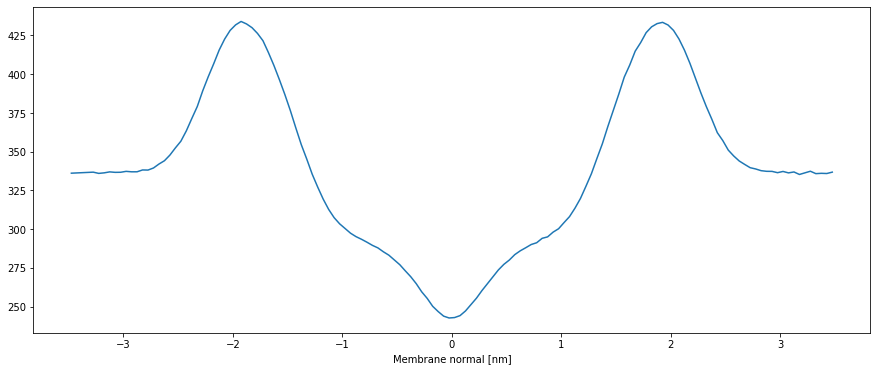

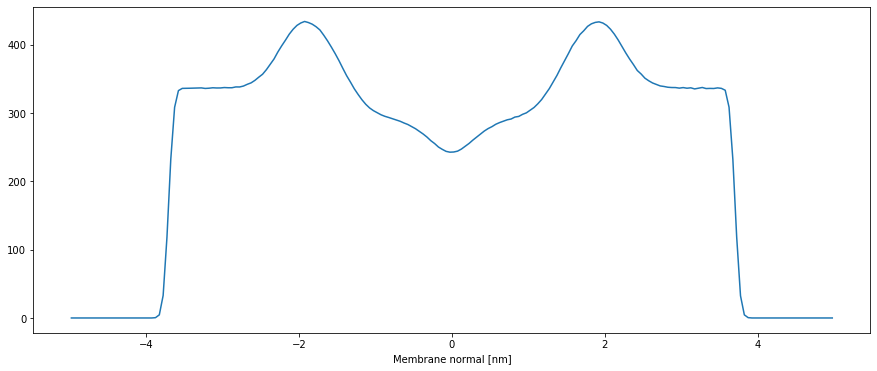

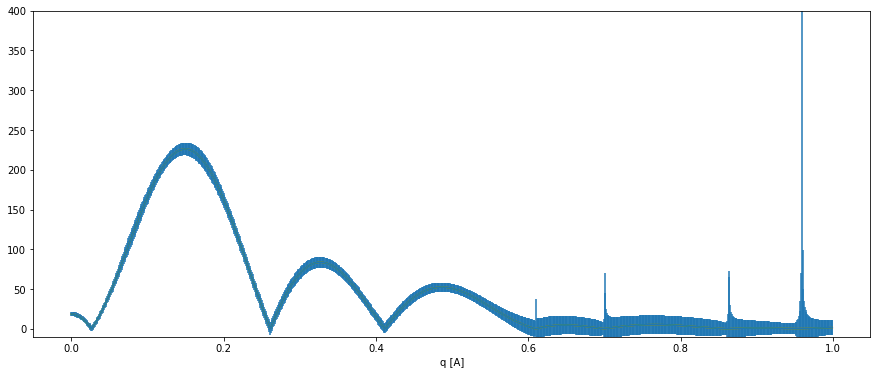

In [37]:
FormFactor('prod.tpr','centered.xtc',200,5,'01-test','resname POPC')
